In [8]:
import torch
import torchvision
import torchvision.transforms as transform
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np
import time

to_float_cuda = {"dtype": torch.float32, "device":"cuda"}

In [9]:
transformer = transform.Compose([
                                transform.Resize(256),
                                transform.CenterCrop(224),
                                transform.ToTensor(),
                                transform.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])
train_dataset = torchvision.datasets.CIFAR10("~/datasets",train=True, transform=transformer,download=True)
trainloader = torch.utils.data.DataLoader(train_dataset,batch_size=64,shuffle=True,num_workers=2)

dev_dataset = torchvision.datasets.CIFAR10(".~/datasets",train=False, transform=transformer,download=True)
devloader = torch.utils.data.DataLoader(dev_dataset,batch_size=64,shuffle=True,num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


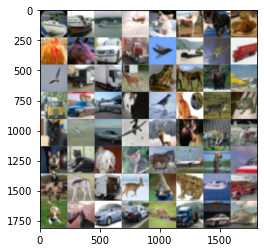

In [10]:
def imshow(img):
  img = img /2 +0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.show

dataiter = iter(trainloader)
images, label = dataiter.next()
imshow(torchvision.utils.make_grid(images))

In [11]:
label

tensor([8, 8, 8, 0, 3, 7, 5, 3, 2, 7, 1, 9, 0, 8, 0, 9, 2, 9, 9, 7, 6, 7, 4, 0,
        9, 1, 0, 3, 2, 3, 4, 6, 3, 2, 1, 0, 4, 4, 3, 4, 3, 3, 5, 2, 7, 0, 4, 0,
        7, 4, 9, 4, 2, 6, 8, 9, 5, 3, 1, 1, 4, 9, 1, 8])

In [12]:
class SE_block (nn.Module):
  '''
  Squeeze and Excitation block
  Some channels may be more important than another, therefore create a weight for number
  of channels allow the network to prioritize different channels.
  Sigmoid is used to ensure the outputs are between 0 and 1.

  Inputs:
  - in_channel: num of channels for the input feature maps (after expand)
  - ratio: Used to reduce dimension in linear layers, original paper default value = 16
  - has_se: Equal Ture when MBConv kernel size is 5, otherwise False
  Outpus:
  - A weighted output with the same shape with input, if has_se == Flase, return identity

  Note:
  - Actual implementaion of SE paper use linear but EfficientNet used Conv2d with kernel size 1 with original input channels (before expand) * 0.25. 
    Here I convert in_channel back to number of channels before expansion and devide by 4 to match the implementation of EffcientNet as close as possible.
    However, I cant use Conv2d without major change after global average pooling. Therefore, I kept the linear layer.
    I suspect it make little difference between the two.
  '''
  def __init__(self,in_channel, channel_expand_factor, ratio= 4):
    super().__init__()

    intermediate_channel = int((in_channel / channel_expand_factor) // ratio)
    
    self.weights = nn.Sequential(
                                nn.AdaptiveAvgPool2d((1,1)),
                                nn.Flatten(),
                                nn.Linear(in_channel,intermediate_channel),
                                nn.ReLU(),
                                nn.Linear(intermediate_channel, in_channel),
                                nn.Sigmoid()
                                )

  def forward (self,x):
      return x * self.weights(x).unsqueeze(-1).unsqueeze(-1)

class MBConv_block(nn.Module):
  '''
  Inputs:
    - channel_expand_factor: channel expand coeffient within inverse bottleneck block
    - keepdim: if ture, keep dimention of input's width, and height the same for output
               if false, input height and width are downsample by a factor of 2 
  Note:
    - Convolution bias parameters are turned off for layer right before batchnorm, since batchnorm eliminate any biases affects
    - Actually implementation use Swish activation
  '''

  def __init__ (self, in_channel, out_channel, kernel_size, drop_rate_= 0.2, channel_expand_factor=6, keepdim=True):
    super().__init__()
    self.drop_rate_ = drop_rate_
    self.residual = keepdim and in_channel == out_channel

    intermidiate_channels = in_channel*channel_expand_factor
    pad = (kernel_size - 1) // 2

    # if keepdim, image size are not changing
    stride = 1 if keepdim else 2

    self.inv_bottleneck_block = nn.Sequential(
                                              nn.Conv2d(in_channel, intermidiate_channels, kernel_size=1, bias=False),
                                              nn.BatchNorm2d(intermidiate_channels),
                                              nn.ReLU(),
                                              nn.Conv2d(intermidiate_channels, intermidiate_channels, kernel_size, stride, pad, groups=intermidiate_channels, bias= False), # Depthwise Conv
                                              nn.BatchNorm2d(intermidiate_channels),
                                              nn.ReLU(),
                                              SE_block(intermidiate_channels, channel_expand_factor),
                                              nn.Conv2d(intermidiate_channels, out_channel, kernel_size=1, bias=False),
                                              nn.BatchNorm2d(out_channel),
                                              )
    

  def forward (self, x):
    
    output = self.inv_bottleneck_block(x)

    # dropout only using where there is a residual connection
    if self.residual:
      return F.dropout(output, self.drop_rate_, self.training)  +  x
    else:
      return output


class MBConv_stage (nn.Module):

  def __init__(self, in_channel_, out_channel_, kernel_size_, channel_expand_factor_, num_layers_, drop_rate_= 0.2, stage_downsample_= True):
    super().__init__()

    module_list = nn.ModuleList()

    for i in range(num_layers_):
      cin = in_channel_ if i == 0 else out_channel_                             # first case where input channels equal actual inputs, otherwise it equals to output channels
      keepdim = False if i == num_layers_ - 1 and stage_downsample_ else True   # last case where we want to downsample the image width and height by a factor of 2 if stage_downsample_ = True
      
      module_list.append(MBConv_block(cin, out_channel_, kernel_size_, drop_rate_, channel_expand_factor_, keepdim))

    self.stage = nn.Sequential(*module_list)
  def forward(self, x):
    return self.stage(x)



In [13]:
class SwishImplementation(torch.autograd.Function):
    @staticmethod
    def forward(ctx, i):
        result = i * torch.sigmoid(i)
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_tensors[0]
        sigmoid_i = torch.sigmoid(i)
        return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))

class MemoryEfficientSwish(nn.Module):
    def forward(self, x):
        return SwishImplementation.apply(x)

# Paper original helper function
def round_filters(filters, width_coefficient, depth_divisor= 8):
    """Round number of filters based on width multiplier."""

    filters *= width_coefficient
    new_filters = int(filters + depth_divisor / 2) // depth_divisor * depth_divisor
    new_filters = max(depth_divisor, new_filters)
    # Make sure that round down does not go down by more than 10%.
    if new_filters < 0.9 * filters:
        new_filters += depth_divisor
    return int(new_filters)

In [14]:
class efficientNet (nn.Module):
  '''
  
  TODO:
    - Figure out how to scale stage 1 and stage 9. ANSWER: stem and top dont scale
    - Base model parameters number are now correct, need to check fi scaling rule. 
        -output channels is round or ceil?
    - There are dropout layer in implementation but not in papaer, ADDED

    - FIND drop rate details

  '''

  def __init__(self,fi=0, num_classes=10):
    super().__init__()

    # alpha = 1.2 **fi    #Depth, num of layers
    # beta = 1.1 **fi     #Width, num of channels
    # gemma = 1.15 **fi   #Resolution, NOT USED in implementation, however, it roughly determine input resolution, B0: 224, B1: 240, B2: 260, B3: 300, B4: 380, B5: 456, B6: 528, B7: 600, L2: 800

    classifier_dropout = {0: 0.2, 1: 0.2, 2: 0.3, 3: 0.3, 4: 0.4, 5: 0.4, 6: 0.5, 7: 0.5, "L2": 0.5}
    width_multiplier = {0: 1, 1: 1, 2: 1.1, 3: 1.2, 4: 1.4, 5: 1.6, 6: 1.8, 7: 2, "L2": 4.3} # Beta ~= 1.1 ** fi
    depth_multiplier = {0: 1, 1: 1.1, 2: 1.2, 3: 1.4, 4: 1.8, 5: 2.2, 6: 2.6, 7: 3.1, "L2": 5.3} # Alpha ~= 1.2 ** fi

    stage_1_param = {"output_channels": round_filters(32, width_multiplier[fi]),
                     "kernel_size": 3}

    stage_2_param = {"output_channels": round_filters(16, width_multiplier[fi]),
                     "kernel_size": 3,
                     "channel_expand_factor": 1,
                     "num_layers": math.ceil(1 * depth_multiplier[fi]),
                     "stage_downsample": False}

    stage_3_param = {"output_channels": round_filters(24, width_multiplier[fi]),
                     "kernel_size": 3,
                     "channel_expand_factor": 6,
                     "num_layers": math.ceil(2 * depth_multiplier[fi]),
                     "stage_downsample": True}

    stage_4_param = {"output_channels": round_filters(40, width_multiplier[fi]),
                     "kernel_size": 5,
                     "channel_expand_factor": 6,
                     "num_layers": math.ceil(2 * depth_multiplier[fi]),
                     "stage_downsample": True}

    stage_5_param = {"output_channels": round_filters(80, width_multiplier[fi]),
                     "kernel_size": 3,
                     "channel_expand_factor": 6,
                     "num_layers": math.ceil(3 * depth_multiplier[fi]),
                     "stage_downsample": True}     

    stage_6_param = {"output_channels": round_filters(112, width_multiplier[fi]),
                     "kernel_size": 5,
                     "channel_expand_factor": 6,
                     "num_layers": math.ceil(3 * depth_multiplier[fi]),
                     "stage_downsample": False}

    stage_7_param = {"output_channels": round_filters(192, width_multiplier[fi]),
                     "kernel_size": 5,
                     "channel_expand_factor": 6,
                     "num_layers": math.ceil(4 * depth_multiplier[fi]),
                     "stage_downsample": True}

    stage_8_param = {"output_channels": round_filters(320, width_multiplier[fi]),
                     "kernel_size": 3,
                     "channel_expand_factor": 6,
                     "num_layers": math.ceil(1 * depth_multiplier[fi]),
                     "stage_downsample": False}

    stage_9_param = {"output_channels": round_filters(1280, width_multiplier[fi]),
                     "kernel_size": 1}

    #TODO
    drop_rate = 0.2

    stage_1 = nn.Sequential(nn.Conv2d(3,stage_1_param["output_channels"],stage_1_param["kernel_size"],stride=2, padding= 1, bias= False),
                            nn.BatchNorm2d(stage_1_param["output_channels"]),
                            nn.ReLU())
    
    stage_2 = MBConv_stage(stage_1_param["output_channels"],stage_2_param["output_channels"],stage_2_param["kernel_size"],stage_2_param["channel_expand_factor"],stage_2_param["num_layers"],drop_rate, stage_2_param["stage_downsample"])

    stage_3 = MBConv_stage(stage_2_param["output_channels"],stage_3_param["output_channels"],stage_3_param["kernel_size"],stage_3_param["channel_expand_factor"],stage_3_param["num_layers"],drop_rate, stage_3_param["stage_downsample"])
                
    stage_4 = MBConv_stage(stage_3_param["output_channels"],stage_4_param["output_channels"],stage_4_param["kernel_size"],stage_4_param["channel_expand_factor"],stage_4_param["num_layers"],drop_rate, stage_4_param["stage_downsample"])
   
    stage_5 = MBConv_stage(stage_4_param["output_channels"],stage_5_param["output_channels"],stage_5_param["kernel_size"],stage_5_param["channel_expand_factor"],stage_5_param["num_layers"],drop_rate, stage_5_param["stage_downsample"])   
                              
    stage_6 = MBConv_stage(stage_5_param["output_channels"],stage_6_param["output_channels"],stage_6_param["kernel_size"],stage_6_param["channel_expand_factor"],stage_6_param["num_layers"],drop_rate, stage_6_param["stage_downsample"])
                              
    stage_7 = MBConv_stage(stage_6_param["output_channels"],stage_7_param["output_channels"],stage_7_param["kernel_size"],stage_7_param["channel_expand_factor"],stage_7_param["num_layers"],drop_rate, stage_7_param["stage_downsample"])
                              
    stage_8 = MBConv_stage(stage_7_param["output_channels"],stage_8_param["output_channels"],stage_8_param["kernel_size"],stage_8_param["channel_expand_factor"],stage_8_param["num_layers"],drop_rate, stage_8_param["stage_downsample"])
    
    stage_9 = nn. Sequential( nn.Conv2d(stage_8_param["output_channels"], stage_9_param["output_channels"], stage_9_param["kernel_size"], bias= False),
                              nn.BatchNorm2d(stage_9_param["output_channels"]),
                              nn.ReLU(),
                              nn.AdaptiveAvgPool2d((1,1)),
                              nn.Flatten(),
                              nn.Dropout(classifier_dropout[fi]),
                              nn.Linear(stage_9_param["output_channels"], num_classes))
    
    self.model = nn.Sequential(stage_1,
                               stage_2,
                               stage_3,
                               stage_4,
                               stage_5,
                               stage_6,
                               stage_7,
                               stage_8,
                               stage_9)
  def forward(self,x):
    return self.model(x);


In [25]:
model = efficientNet(fi=0, num_classes=10).cuda()
test = model(images[0].unsqueeze(0).cuda())
test.shape

torch.Size([1, 10])

In [26]:
summary(model, (3,224,224),30)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [30, 32, 112, 112]             864
       BatchNorm2d-2         [30, 32, 112, 112]              64
              ReLU-3         [30, 32, 112, 112]               0
            Conv2d-4         [30, 32, 112, 112]           1,024
       BatchNorm2d-5         [30, 32, 112, 112]              64
              ReLU-6         [30, 32, 112, 112]               0
            Conv2d-7         [30, 32, 112, 112]             288
       BatchNorm2d-8         [30, 32, 112, 112]              64
              ReLU-9         [30, 32, 112, 112]               0
AdaptiveAvgPool2d-10             [30, 32, 1, 1]               0
          Flatten-11                   [30, 32]               0
           Linear-12                    [30, 8]             264
             ReLU-13                    [30, 8]               0
           Linear-14                   

In [17]:
import torch
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import random
import pickle
import time
import math
from tqdm import trange


def Sampler(model_fn, model_args, train_loader, val_loader, num_model, epoch, lr_lowbound=-5, lr_highbound=0):
  '''
  Use for hyperparameter tuning. Quickly sample learing rates
  Inputs:
    - model_fn: model function
    - model_args: model arguments
    - num_model: number of models for sampling

  '''

  for i in range(num_model):
    model = model_fn(**model_args)
    lr = 10 ** random.uniform(lr_lowbound, lr_highbound)

    print(f'lr: {lr:.4e}', end=' ')
    solver = Solver(model, train_loader, val_loader, fp16= False)
    solver.train(epoch, lr)




class Solver(object):
  '''
  Default/ Hard-coded Behavior:
    Using NVDIA GPU, Cuda, Cudnn
    optimizer = Adam
    loss function = Cross Entropy Loss
    print initial loss after the very first iteration as model sanity check

  '''

  def __init__(self, model, train_loader, eval_loader, fp16= True, random_seed=0):
    '''
    Inputs:
      - fp16:               if True, both model and data are using torch.float16 to save GPU memory, otherwise using torch.float32.
                            NOTE: when using fp16, Adam optimizer's eps is set to larger than default value to prevent overflow
      - random_seed:        random seed that make output deterministic. See detail in fixrandomseed function
      
    '''
    self.model = model
    self.train_loader = train_loader
    self.eval_loader = eval_loader

    self.epoch_loss_history= []
    self.averge_loss_history = []
    self.train_acc_history = []
    self.val_acc_history = []
    self.ratios = []

    torch.cuda.synchronize()
    torch.backends.cudnn.benchmark = True
    self._fixrandomseed(random_seed)

    self.to_float_cuda = {"dtype": torch.float16 if fp16 else torch.float32, "device":"cuda"}
    self.eps = 1e-5 if fp16 else 1e-8

    self.model.to(**self.to_float_cuda) # model need to be moved before constructing optimizer
    
    self.optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, eps=self.eps) 
    self.loss_fn = torch.nn.CrossEntropyLoss()
  

  def train(self, epoch, lr=1e-4 , print_every_iter=1000, check_every_epoch=1000, verbose=False, checkpoint_name= None, tf_board=False):
    '''
    Inputs:
      - print_every_iter:   print loss *loss* and *accumilated time* every number of iters, verbose always need to be set to True
      - check_every_epoch:  checkpoint for every number of epoch. See details behaviors in the private checkpoint function
      - verbose:            print detail loss during training, and plot loss at checkpoint otherwise, only print in checkpoint
      - checkpoint_name:    if not None, will save model using pickel at checkpoint
    '''
    self.epoch = epoch
    self.lr = lr
    self.check_every_epoch = check_every_epoch
    self.verbose = verbose
    self.checkpoint_name = checkpoint_name

    if tf_board:
      self.writer = SummaryWriter()

    # can change lr when call train again
    if self.optimizer.param_groups[0]['lr'] != lr:
      for p in self.optimizer.param_groups:
        p['lr'] = lr

    num_batch = len(self.train_loader)
    self.model.train()
    for i in range(1, epoch+1):

      total_loss = 0
      iter_loss_history = []
      start_time = time.time()
      Y_pred_all = []
      Y_tr_all = []

      for j, data in enumerate(self.train_loader):
        
        Xtr, Ytr = data
        Xtr, Ytr = Xtr.to(**self.to_float_cuda), Ytr.cuda()

        # alternative of model.zero_grad(). This way is more efficient
        for param in self.model.parameters():
          param.grad = None
        # self.model.zero_grad(set_to_none=True)
        
        y_pred = self.model(Xtr)
        loss = self.loss_fn(y_pred,Ytr)

        total_loss += loss.item()

        loss.backward()
        self.optimizer.step()

        # print initial loss as sanity check
        if verbose and i == 1 and j == 0 :
          print(f'initialal loss: {loss:.5f}')

        # print training loss per number of iterations
        if verbose and j % print_every_iter == 0:
          print(f"Iteration {j}/{num_batch}, loss = {(total_loss / (j+1)):.5f}, took {(time.time() - start_time):.2f} seconds")
        
        # Iter Book keeping
        Y_pred_all.append(y_pred)
        Y_tr_all.append(Ytr)
        iter_loss_history.append(loss.item())



      epoch_loss = total_loss / num_batch

      if verbose:
        print(f"Epoch: {i}/{epoch}, loss = {epoch_loss:.5f}, took {time.time() - start_time:.2f} seconds")

      # Epoch Book keeping
      self.epoch_loss_history.append(iter_loss_history)
      self.averge_loss_history.append(epoch_loss)

      if tf_board: 
        self.writer.add_scalar('Epoch loss', epoch_loss, i)

      
      if i % check_every_epoch == 0 or i == epoch:
        # check train accuracy
        Y_pred_all = torch.argmax(torch.cat(Y_pred_all),dim=1)
        Y_tr_all = torch.cat(Y_tr_all)
        train_accuracy = (Y_pred_all == Y_tr_all).float().mean()

        # check val accuracy
        val_accuracy = self._check_accuracy(self.eval_loader)

        # check update ratio
        ratio = self._check_update_ratio()

        print(f'Epoch: {i}/{epoch}, Loss: {epoch_loss:.4f} train acc: {train_accuracy:.4f}, val acc: {val_accuracy:.4f}, update ratio: {ratio:.2e}')

        # Checkpoint Book keeping
        self.train_acc_history.append(train_accuracy)
        self.val_acc_history.append(val_accuracy)
        self.ratios.append(ratio)

        if checkpoint_name is not None:
          self._save_checkpoint(epoch=i)

        if tf_board:
          self.writer.add_scalar('train_accuracy', train_accuracy, i)
          self.writer.add_scalar('val_accuracy', val_accuracy, i)
  
    if verbose:
      self.plot()

  @torch.no_grad()
  def _check_update_ratio(self):
    '''
    Check the ratio between weights and graidents.
    Ideal ratio is around 1e-3
    '''
    num_param = 0
    param_ratio = 0
    update_ratio = 0
    for param in self.model.parameters():
      num_param += 1
      param_ratio += torch.norm(param)
      update_ratio += torch.norm(param.grad)

    param_ratio /= num_param
    update_ratio = update_ratio/ num_param * self.lr
    return (update_ratio / param_ratio).item()

  @torch.no_grad()
  def _check_accuracy(self, data_loader, num_sample=None):
    '''
    if num_sample is provided, will sub sample data loader to the designated amount of samples and double the batch size for efficency.
    (Can double the batch size during evaluation since no grads are needed)

    Inputs:
      - data_loader:    Pytorch dataloader object
      - num_sample:     number of samples that are *randomly* picked in the dataloader
    Outputs:
      - acc:            float, accuracy of the dataloader
    
    TODO:
    - Want randomly pick data to calculate accuracy? is making it more deterministic better?
    '''
    self.model.eval()

    if num_sample is not None:
      sub_dataset = torch.utils.data.Subset(data_loader.dataset, torch.randint(high=len(data_loader.dataset),size=(num_sample,)))
      sub_data_loader = torch.utils.data.DataLoader(sub_dataset,data_loader.batch_size*2, num_workers=2,pin_memory=True,)
    else:
      sub_data_loader = data_loader

    Ypred = []
    Yall = []
    for data in sub_data_loader:
      X, Y = data
      X, Y = X.to(**self.to_float_cuda), Y.cuda()

      scores = self.model(X)
      Ypred.append(torch.argmax(scores,dim=1))
      Yall.append(Y)
    
    Ypred = torch.cat(Ypred)
    Yall = torch.cat(Yall)
    acc = (Ypred == Yall).float().mean()

    self.model.train()
    return acc.item()

  def _save_checkpoint(self, epoch):

    checkpoint = {
      'model': self.model,
      'epoch': self.epoch,
      'lr': self.lr,
      'loss history': self.epoch_loss_history,
      'train_acc_history': self.train_acc_history,
      'val_acc_history': self.val_acc_history,
      'scales' : self.scales
    }
    filename = f'{self.checkpoint_name}_epoch_{epoch}.pkl'

    if self.verbose:
      print(f'Saving checkpoint to "{filename}"')

    with open(filename, 'wb') as f:
      pickle.dump(checkpoint, f)
    

  def plot(self):
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.plot(self.epoch_loss_history,'oc')
    plt.plot(self.averge_loss_history,'-b')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(122)
    plt.plot(self.train_acc_history,'-o', label='train')
    plt.plot(self.val_acc_history,'-o', label='validation')
    plt.xlabel(f'Every {self.check_every_epoch} Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

  def _fixrandomseed(self, seed=0):
    '''
    Fix random seed to get deterministic outputs
    '''
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # random.seed(seed)

# New Section

In [18]:
transformer = transform.Compose([
                                transform.Resize(256),
                                transform.CenterCrop(224),
                                transform.ToTensor(),
                                transform.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])
train_dataset = torchvision.datasets.CIFAR10("~/datasets",train=True, transform=transformer,download=True)
trainloader = torch.utils.data.DataLoader(train_dataset,batch_size=64,shuffle=True,num_workers=2)

dev_dataset = torchvision.datasets.CIFAR10("~/datasets",train=False, transform=transformer,download=True)
devloader = torch.utils.data.DataLoader(dev_dataset,batch_size=64,shuffle=True,num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [19]:
small_train_data = torch.utils.data.Subset(train_dataset, torch.arange(0, 1000))
small_train_loader = torch.utils.data.DataLoader(small_train_data,batch_size=48, num_workers=2,pin_memory=True)

small_dev_data = torch.utils.data.Subset(dev_dataset, torch.arange(0, 100))
small_dev_loader = torch.utils.data.DataLoader(small_dev_data,batch_size=40, num_workers=2,pin_memory=True)

In [20]:
model = efficientNet(fi=0, num_classes=10)
solver = Solver(model, small_train_loader, small_dev_loader)

In [21]:
solver.train(lr= 1e-4, epoch= 5, print_every_iter= 5, check_every_epoch= 1, verbose=True, checkpoint_name=None)

initialal loss: 2.35742
Iteration 0/21, loss = 2.35742, took 2.60 seconds
Iteration 5/21, loss = 2.62598, took 3.23 seconds
Iteration 10/21, loss = 2.50515, took 3.86 seconds
Iteration 15/21, loss = 2.44775, took 4.48 seconds


KeyboardInterrupt: 

In [ ]:
solver.plot()

In [ ]:
solver.optimizer.param_groups[0]['lr']

In [ ]:
fn = efficientNet
args = {'fi':0, 'num_classes':10}
Sampler(fn, args, small_train_loader, small_dev_loader, num_model=20, epoch=2, lr_lowbound=-5, lr_highbound=0.5)

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.plot(solver.epoch_loss_history,'oc')
plt.plot(solver.averge_loss_history,'-b')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(132)
plt.plot(solver.train_acc_history,'-o', label='train')
plt.plot(solver.val_acc_history,'-o', label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(133)
plt.plot(solver.ratios,'-o')
plt.xlabel('Epoch')
plt.ylabel('Scale Ratio')
plt.show()

In [ ]:
optim = torch.optim.Adam(model.parameters(), lr=1e-3)